In [1]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
news = load_dataset("fancyzhx/ag_news")
news

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
news["train"][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)


news_tokenized = news.map(preprocess_function, batched=True)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [5]:
news_tokenized["train"][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [6]:
news_split = news_tokenized["train"].train_test_split(test_size=0.2)
news_train, news_val = news_split["train"], news_split["test"]
news_test = news_tokenized["test"]

In [7]:
len(news_train), len(news_val), len(news_test)

(96000, 24000, 7600)

In [9]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = 4  # 마지막에 예측해야 하는 분류 문제의 class 개수

model = AutoModelForSequenceClassification.from_config(config)

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="news_classifier",  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="eval_accuracy",  # best model을 accuracy 기준으로 선정
    greater_is_better=True,
)

In [11]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [12]:
from transformers import EarlyStoppingCallback
from callback_plot import PlotCallback
from callback_best_model import BestModelCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=news_train,
    eval_dataset=news_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        PlotCallback(),
        BestModelCallback(),
        EarlyStoppingCallback(early_stopping_patience=2),
    ],
)

  0%|          | 0/7500 [00:00<?, ?it/s]

{'loss': 0.4101, 'grad_norm': 3.003693103790283, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.2761739194393158, 'eval_accuracy': 0.9073333333333333, 'eval_runtime': 16.1144, 'eval_samples_per_second': 1489.35, 'eval_steps_per_second': 11.667, 'epoch': 1.0}


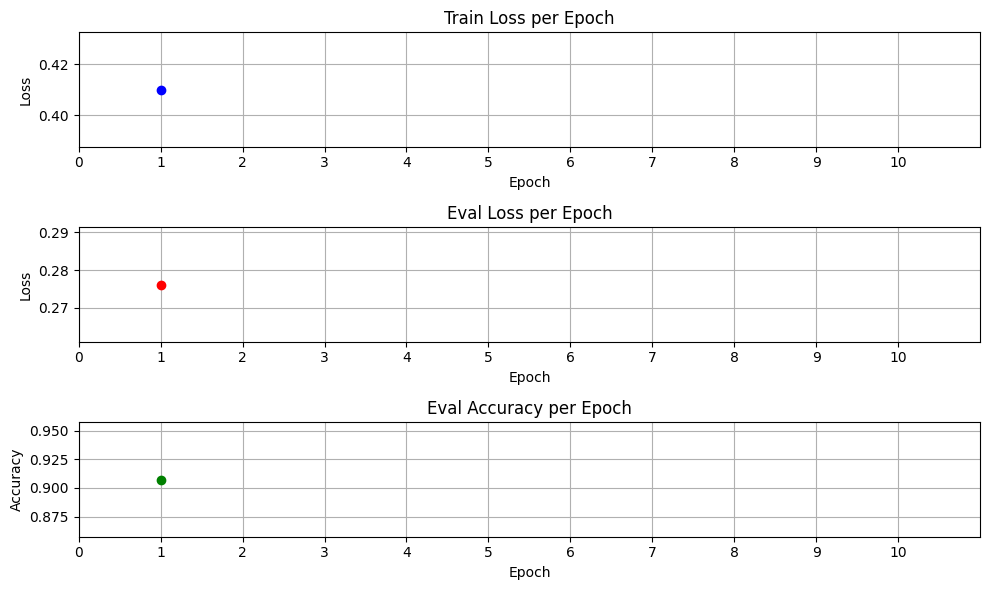

{'loss': 0.2042, 'grad_norm': 1.358650803565979, 'learning_rate': 0.0008, 'epoch': 2.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.25525617599487305, 'eval_accuracy': 0.9137916666666667, 'eval_runtime': 19.2285, 'eval_samples_per_second': 1248.147, 'eval_steps_per_second': 9.777, 'epoch': 2.0}


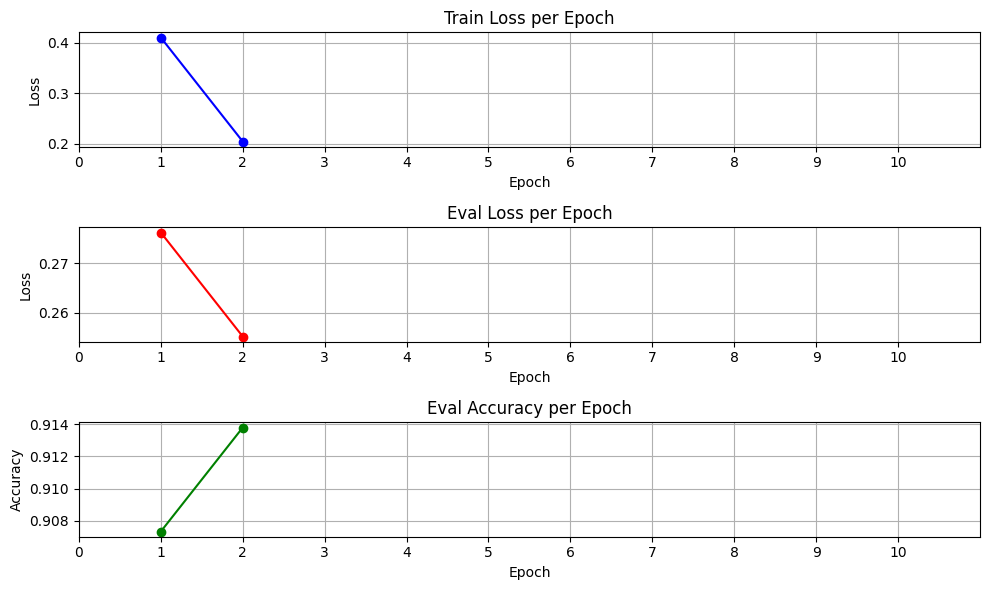

{'loss': 0.1445, 'grad_norm': 1.0534656047821045, 'learning_rate': 0.0007, 'epoch': 3.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.2706391513347626, 'eval_accuracy': 0.9147083333333333, 'eval_runtime': 20.1895, 'eval_samples_per_second': 1188.739, 'eval_steps_per_second': 9.312, 'epoch': 3.0}


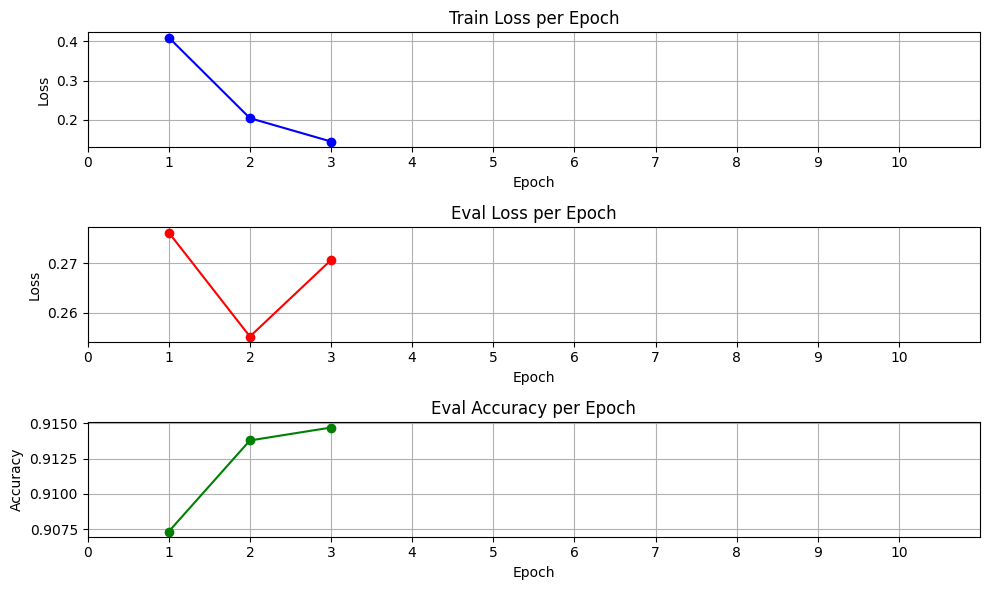

{'loss': 0.1058, 'grad_norm': 1.0908480882644653, 'learning_rate': 0.0006, 'epoch': 4.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.3261222839355469, 'eval_accuracy': 0.909375, 'eval_runtime': 18.954, 'eval_samples_per_second': 1266.223, 'eval_steps_per_second': 9.919, 'epoch': 4.0}


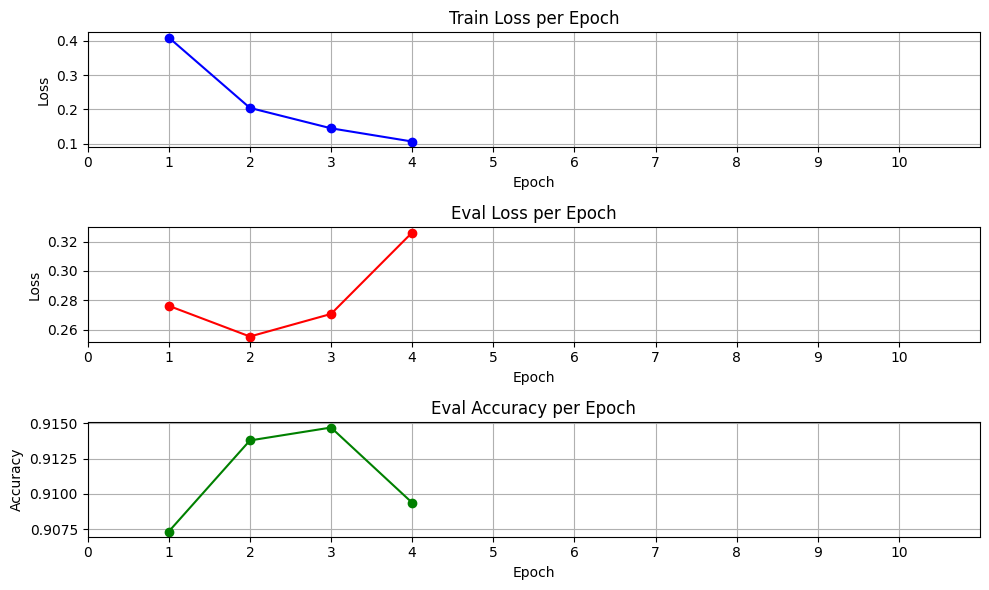

{'loss': 0.0775, 'grad_norm': 1.5364909172058105, 'learning_rate': 0.0005, 'epoch': 5.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.3638702929019928, 'eval_accuracy': 0.9089166666666667, 'eval_runtime': 17.8608, 'eval_samples_per_second': 1343.728, 'eval_steps_per_second': 10.526, 'epoch': 5.0}


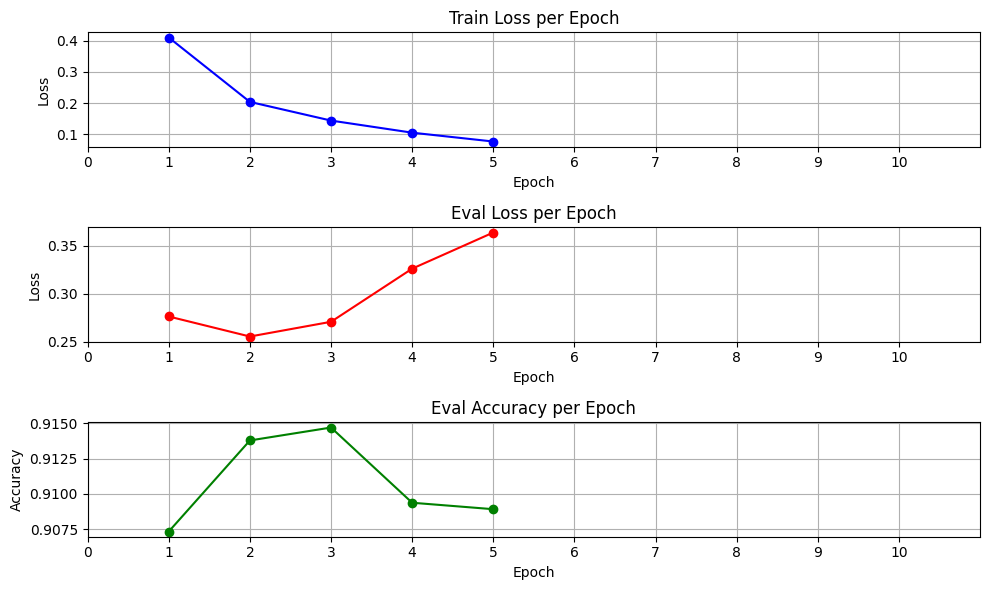

{'train_runtime': 662.5783, 'train_samples_per_second': 1448.885, 'train_steps_per_second': 11.319, 'train_loss': 0.18840401916503907, 'epoch': 5.0}
Best model was saved at: news_classifier/checkpoint-2250
Best epoch: 3.0
Best eval_accuracy: 0.9147083333333333


TrainOutput(global_step=3750, training_loss=0.18840401916503907, metrics={'train_runtime': 662.5783, 'train_samples_per_second': 1448.885, 'train_steps_per_second': 11.319, 'total_flos': 28510119152640.0, 'train_loss': 0.18840401916503907, 'epoch': 5.0})

In [14]:
trainer.train()

In [15]:
trainer.evaluate(news_test)

  0%|          | 0/60 [00:00<?, ?it/s]

{'eval_loss': 0.27632272243499756,
 'eval_accuracy': 0.911578947368421,
 'eval_runtime': 7.0639,
 'eval_samples_per_second': 1075.888,
 'eval_steps_per_second': 8.494,
 'epoch': 5.0}

In [16]:
trainer.save_model()

In [17]:
from transformers import pipeline


classifier = pipeline("text-classification", model="./news_classifier/", device="mps")
print(
    classifier(
        "UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month."
    )
)

[{'label': 'LABEL_0', 'score': 0.9961228966712952}]


In [25]:
from transformers import AutoConfig

id2label = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
label2id = {
    "World": 0,
    "Sports": 1,
    "Business": 2,
    "Sci/Tech": 3,
}

config = AutoConfig.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=4,
    hidden_dropout_prob=0.3,  # Dropout 확률 설정
    id2label=id2label,
    label2id=label2id,
)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    config=config,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [27]:
for param in model.distilbert.parameters():
    param.requires_grad = False

이러면 모델 구현은 완전히 마쳤습니다.
다음은 distilbert를 pre-train할 때 사용했던 tokenizer를 불러오고, 이 tokenizer를 가지고 이전과 똑같이 imdb dataset를 전처리합니다.


In [22]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)


news_tokenized = news.map(preprocess_function, batched=True)
news_split = news_tokenized["train"].train_test_split(test_size=0.2)
news_train, news_val = news_split["train"], news_split["test"]
news_test = news_tokenized["test"]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

나머지는 기존의 학습과정과 완전히 동일합니다. `training_args`는 기존과 똑같이 활용할 때 distilbert를 fine-tuning하는 코드는 다음과 같습니다.


  0%|          | 0/1500 [00:00<?, ?it/s]

{'loss': 0.3175, 'grad_norm': 0.45771387219429016, 'learning_rate': 0.001, 'epoch': 1.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.28516894578933716, 'eval_accuracy': 0.89575, 'eval_runtime': 182.1957, 'eval_samples_per_second': 131.727, 'eval_steps_per_second': 1.032, 'epoch': 1.0}


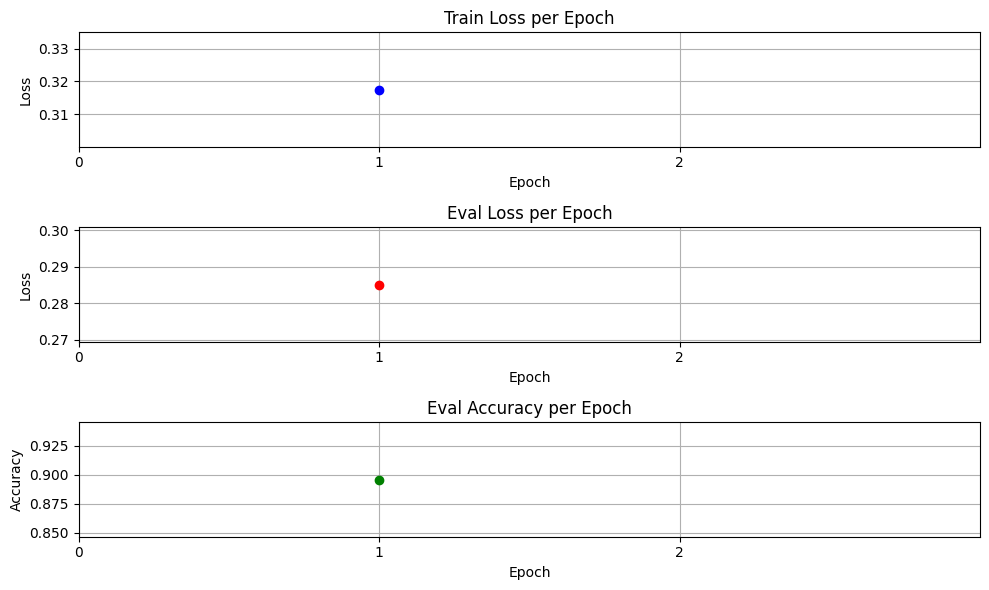

{'loss': 0.2759, 'grad_norm': 0.5386624932289124, 'learning_rate': 0.001, 'epoch': 2.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.2555958926677704, 'eval_accuracy': 0.90675, 'eval_runtime': 246.0154, 'eval_samples_per_second': 97.555, 'eval_steps_per_second': 0.764, 'epoch': 2.0}


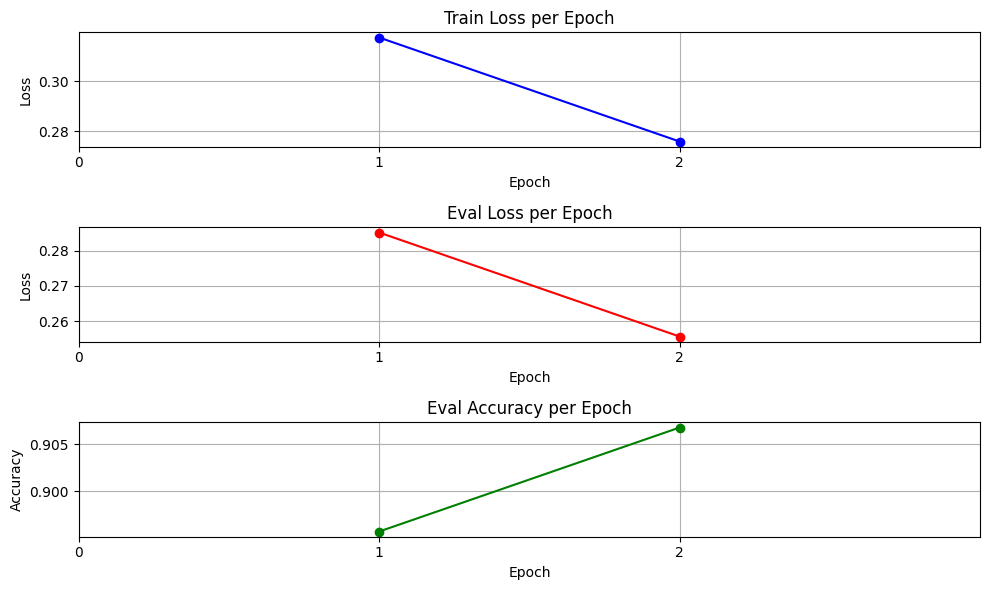

{'train_runtime': 1586.101, 'train_samples_per_second': 121.052, 'train_steps_per_second': 0.946, 'train_loss': 0.29671319580078126, 'epoch': 2.0}
Best model was saved at: news_classifier_01/checkpoint-1500
Best epoch: 2.0
Best eval_accuracy: 0.90675


TrainOutput(global_step=1500, training_loss=0.29671319580078126, metrics={'train_runtime': 1586.101, 'train_samples_per_second': 121.052, 'train_steps_per_second': 0.946, 'total_flos': 7927231217869824.0, 'train_loss': 0.29671319580078126, 'epoch': 2.0})

In [28]:
training_args = TrainingArguments(
    output_dir="news_classifier_01",  # 모델, log 등을 저장할 directory
    num_train_epochs=2,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="eval_accuracy",  # best model을 accuracy 기준으로 선정
    greater_is_better=True,
    lr_scheduler_type="constant",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=news_train,
    eval_dataset=news_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        PlotCallback(),
        BestModelCallback(),
        EarlyStoppingCallback(early_stopping_patience=2),
    ],
)


trainer.train()
# trainer.save_model()

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 3000
    training_args.learning_rate = 8e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-1500")
    # 이 블록 내에서만 경고가 무시됨

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 4500
    training_args.learning_rate = 6e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-3000")
    # 이 블록 내에서만 경고가 무시됨

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 6000
    training_args.learning_rate = 4e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-4500")
    # 이 블록 내에서만 경고가 무시됨

In [ ]:
import warnings

# 경고를 임시로 끄기
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    training_args.num_train_epochs = 10
    training_args.max_steps = 7500
    training_args.learning_rate = 2e-4
    trainer.train(resume_from_checkpoint="./hf_transformer_01/checkpoint-6000")
    # 이 블록 내에서만 경고가 무시됨

In [119]:
trainer.save_model()

학습한 모델에 대한 결과는 다음과 같습니다.


In [ ]:
trainer.predict(news_test)

In [ ]:
classifier = pipeline(
    "text-classification", model="./news_classifier_01/", device="mps"
)
print(
    classifier(
        "UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month."
    )
)